In [21]:
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sparse
from ast import literal_eval
import time
from matplotlib import colors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [22]:
def tfidf_names(names):
    """ return cosine similarity matrix: CSM[names1_index][names2_index] = cosine similarity score for an entry in names1 and names2."""
    t1 = time.time()
    analyzer = "char" #[‘word’, ‘char’, ‘char_wb’]
    ngram_range = (2,4) #feature unit: 1 whole word
    max_df = 1.0 #default
    min_df = 1 #means no lower threshold
    binary = False #Take mutiple occurence of a word in name into account
    use_idf = True #Take unit importance in the dataset into accout
    smooth_idf = True #prevent zero division ?
    norm = None #each vector is nomalized so their dot product is cosine similarity
    vectorizer = TfidfVectorizer(analyzer = analyzer, ngram_range = ngram_range, max_df = max_df,
                            min_df = min_df, binary = binary, use_idf = use_idf, smooth_idf = smooth_idf, norm = norm)
    CSM_all_names = vectorizer.fit_transform(names)
    preprocessor = vectorizer.build_preprocessor()
    t = time.time()-t1
    print("Match COMPLETED IN:", t)
    return vectorizer, preprocessor, CSM_all_names

def handle_tfidf_score(tfidf1, tfidf2):
    """
    Convert tfidf scorrs to similarity scores
    RAM intensive
    """
    res_m = cosine_similarity(tfidf1, tfidf2) 
    return res_m

# Load & clean data

In [23]:
tags_df = pd.read_csv("tags_count.csv")
tags_df = tags_df[['tag','tag_count']]
tags_df

In [25]:
tags = tags_df.tag.str.lower().unique()
tags_df = 0
np.save("unique_tags.npy",tags)

In [26]:
cosine_threshold = 0.3
fuzz_threshold = 75
i_step = 10000
k_step = 10000
for i in range(0,len(tags), i_step):  
    all_fields_scores = []
    for k in range(i, len(tags), k_step):
        print(i,k)
        time_start = time.time()
        temp_tags = np.concatenate([tags[i:min(len(tags),i+i_step)],
                                        tags[k:min(len(tags),k+k_step)]])
        _,_,CSM_tags = tfidf_names(temp_tags)
        time_end = time.time()
        t2_start = min(len(tags)-i,i_step)
        res_CSM  = handle_tfidf_score(CSM_tags.tocsr()[0:t2_start],
                                      CSM_tags.tocsr()[t2_start:-1])
        time_end = time.time()     
        fields_matched_1 = np.argwhere((res_CSM>cosine_threshold)&(res_CSM<0.999))
        for t1, t2 in fields_matched_1:
            t2 = t2_start+t2
            fuzz_score = fuzz.ratio(temp_tags[t1],temp_tags[t2])
            if fuzz_score>fuzz_threshold and temp_tags[t1] !=temp_tags[t2]: 
                temp = {"word1":temp_tags[t1],"word2":temp_tags[t2],
                        "consine_score":res_CSM[t1,t2-t2_start], "fuzz_score": fuzz_score} 
                all_fields_scores.append(temp)
        time_end = time.time()
        print("how long it takes for each iter:",time_end-time_start)
        print(len(all_fields_scores))
    fields_scores = pd.DataFrame(all_fields_scores)
    fields_scores.to_csv(f"keywords_match_cleaned_{i//10000}_{k//10000}.csv")

0 0
Match COMPLETED IN: 0.45604491233825684
how long it takes for each iter: 9.3663489818573
136281
0 10000
Match COMPLETED IN: 0.3910651206970215
how long it takes for each iter: 6.394795894622803
222336
0 20000
Match COMPLETED IN: 0.36916375160217285
how long it takes for each iter: 6.828638076782227
299280
0 30000
Match COMPLETED IN: 0.4615490436553955
how long it takes for each iter: 8.48077392578125
403195
0 40000
Match COMPLETED IN: 0.4651658535003662
how long it takes for each iter: 12.825822114944458
560979
0 50000
Match COMPLETED IN: 0.6105372905731201
how long it takes for each iter: 9.315783977508545
655473
0 60000
Match COMPLETED IN: 0.5037040710449219
how long it takes for each iter: 14.828778982162476
834748
0 70000
Match COMPLETED IN: 0.5552618503570557
how long it takes for each iter: 9.637748003005981
925419
0 80000
Match COMPLETED IN: 0.513498067855835
how long it takes for each iter: 3.715549945831299
930994
0 90000
Match COMPLETED IN: 0.5229911804199219
how long it 

Match COMPLETED IN: 0.5418648719787598
how long it takes for each iter: 3.4571568965911865
1947188
60000 130000
Match COMPLETED IN: 0.32352685928344727
how long it takes for each iter: 1.4994890689849854
1947736
70000 70000
Match COMPLETED IN: 0.5150339603424072
how long it takes for each iter: 37.62282109260559
427078
70000 80000
Match COMPLETED IN: 0.5146708488464355
how long it takes for each iter: 7.304361820220947
434606
70000 90000
Match COMPLETED IN: 0.5628609657287598
how long it takes for each iter: 4.611541032791138
438291
70000 100000
Match COMPLETED IN: 0.6421387195587158
how long it takes for each iter: 5.712400913238525
442077
70000 110000
Match COMPLETED IN: 0.538341760635376
how long it takes for each iter: 6.390406131744385
446475
70000 120000
Match COMPLETED IN: 0.8702583312988281
how long it takes for each iter: 5.15012788772583
452932
70000 130000
Match COMPLETED IN: 0.48429298400878906
how long it takes for each iter: 2.4297478199005127
454964
80000 80000
Match COM

In [28]:
fields_scores = pd.DataFrame(all_fields_scores)
fields_scores

,word1,word2,consine_score,fuzz_score
0,'956231011','956231082',0.494999,82
1,'956231011','956231319',0.352410,82
2,'956231011','956231630',0.344716,82
3,'956231011','956231915',0.331418,82
4,'956231011','956333101',0.300211,82
...,...,...,...,...
13604,'959711779','956471177',0.375468,82
13605,'959816964','956816960',0.380566,82
13606,'960076235','956506235',0.314763,82
13607,'mtf2015','mtf2014',0.791455,89


In [29]:
fields_scores.to_csv(f"keywords_match.csv")

In [30]:
len(all_fields_scores)

13609

In [31]:
pd.DataFrame(all_fields_scores).drop_duplicates(subset = ["word1","word2"])

,word1,word2,consine_score,fuzz_score
0,'956231011','956231082',0.494999,82
1,'956231011','956231319',0.352410,82
2,'956231011','956231630',0.344716,82
3,'956231011','956231915',0.331418,82
4,'956231011','956333101',0.300211,82
...,...,...,...,...
13604,'959711779','956471177',0.375468,82
13605,'959816964','956816960',0.380566,82
13606,'960076235','956506235',0.314763,82
13607,'mtf2015','mtf2014',0.791455,89


In [32]:
fields_scores.drop_duplicates()

,word1,word2,consine_score,fuzz_score
0,'956231011','956231082',0.494999,82
1,'956231011','956231319',0.352410,82
2,'956231011','956231630',0.344716,82
3,'956231011','956231915',0.331418,82
4,'956231011','956333101',0.300211,82
...,...,...,...,...
13604,'959711779','956471177',0.375468,82
13605,'959816964','956816960',0.380566,82
13606,'960076235','956506235',0.314763,82
13607,'mtf2015','mtf2014',0.791455,89


# Draw Network

In [68]:
import networkx as nx
import re
pat = r'^\'\d+\'$'

In [91]:
df1 = pd.read_csv('keywords_match_cleaned_0_13.csv',index_col=0)
df1 = df1[~df1["word1"].str.contains(pat)]
df1 = df1.reset_index(drop=True)
df1
# df["digit"] = df.word1.apply(lambda x: True if re.match(r'^\d+$',x) else False)

,word1,word2,consine_score,fuzz_score
0,'ppc.advck','advck',0.564603,78
1,'whconv','whconv1',0.745728,94
2,'wcunlink','unlinked',0.349683,80
3,'wcunlink','wclink',0.425299,89
4,'advck082619','advck090919',0.504998,77
...,...,...,...,...
608918,'mbb2014','mtf2014',0.328249,78
608919,'mad','maddie',0.391795,77
608920,'mte2015','mtf2015',0.367335,89
608921,'mgo2015','mtf2015',0.302921,78


In [111]:
df2 = pd.read_csv('keywords_match_cleaned_13_13.csv')
# need to read 13 times for 13 files
df2 = df2.iloc[: , 1:]
df2 = df2[~df2["word1"].str.contains(pat)]
df2 = df2.reset_index(drop=True)
df2

,word1,word2,consine_score,fuzz_score
0,'mtf2015','mtf2014',0.791455,89
1,'mtf2014','mtf2015',0.791455,89


In [112]:
ndf = pd.concat([ndf, df2])
ndf = ndf.reset_index(drop=True)
ndf

,word1,word2,consine_score,fuzz_score
0,'ppc.advck','advck',0.564603,78
1,'whconv','whconv1',0.745728,94
2,'wcunlink','unlinked',0.349683,80
3,'wcunlink','wclink',0.425299,89
4,'advck082619','advck090919',0.504998,77
...,...,...,...,...
9442597,'schedulereleaseemail20211413','schedulereleaseemail20212677',0.655914,87
9442598,'schedulereleaseemail20211413','schedulereleaseemail20211353',0.726777,93
9442599,'2021ackbafnew03.31.21','2021ackbafnew04.06.21',0.670183,87
9442600,'mtf2015','mtf2014',0.791455,89


In [129]:
ndf.to_csv('allmergedscores.csv')

In [116]:
len(ndf.word2.unique())

6991

In [128]:
countword1=ndf['word2'].value_counts()
countword1.head(4000)

'schedulereleaseemail20210668'    3976
'schedulereleaseemail20212015'    3976
'schedulereleaseemail20212484'    3976
'schedulereleaseemail20211779'    3976
'schedulereleaseemail20212530'    3976
                                  ... 
'mbb1986'                           96
'mbb1997'                           96
'mtr1998'                           95
'mtr1995'                           95
'mtr1982'                           95
Name: word2, Length: 4000, dtype: int64

In [121]:
countword1=ndf['word1'].value_counts()
countword1

'schedulereleaseemail20213924'    3976
'schedulereleaseemail20210872'    3976
'schedulereleaseemail20212363'    3976
'schedulereleaseemail20212065'    3976
'schedulereleaseemail20212267'    3976
                                  ... 
'wro2016'                            1
'08pb.update1'                       1
'caflstailgate'                      1
'childrens'                          1
'fb15nopay'                          1
Name: word1, Length: 6704, dtype: int64

In [64]:
df['word1'][959184]

"'959828632'"

KeyboardInterrupt: 

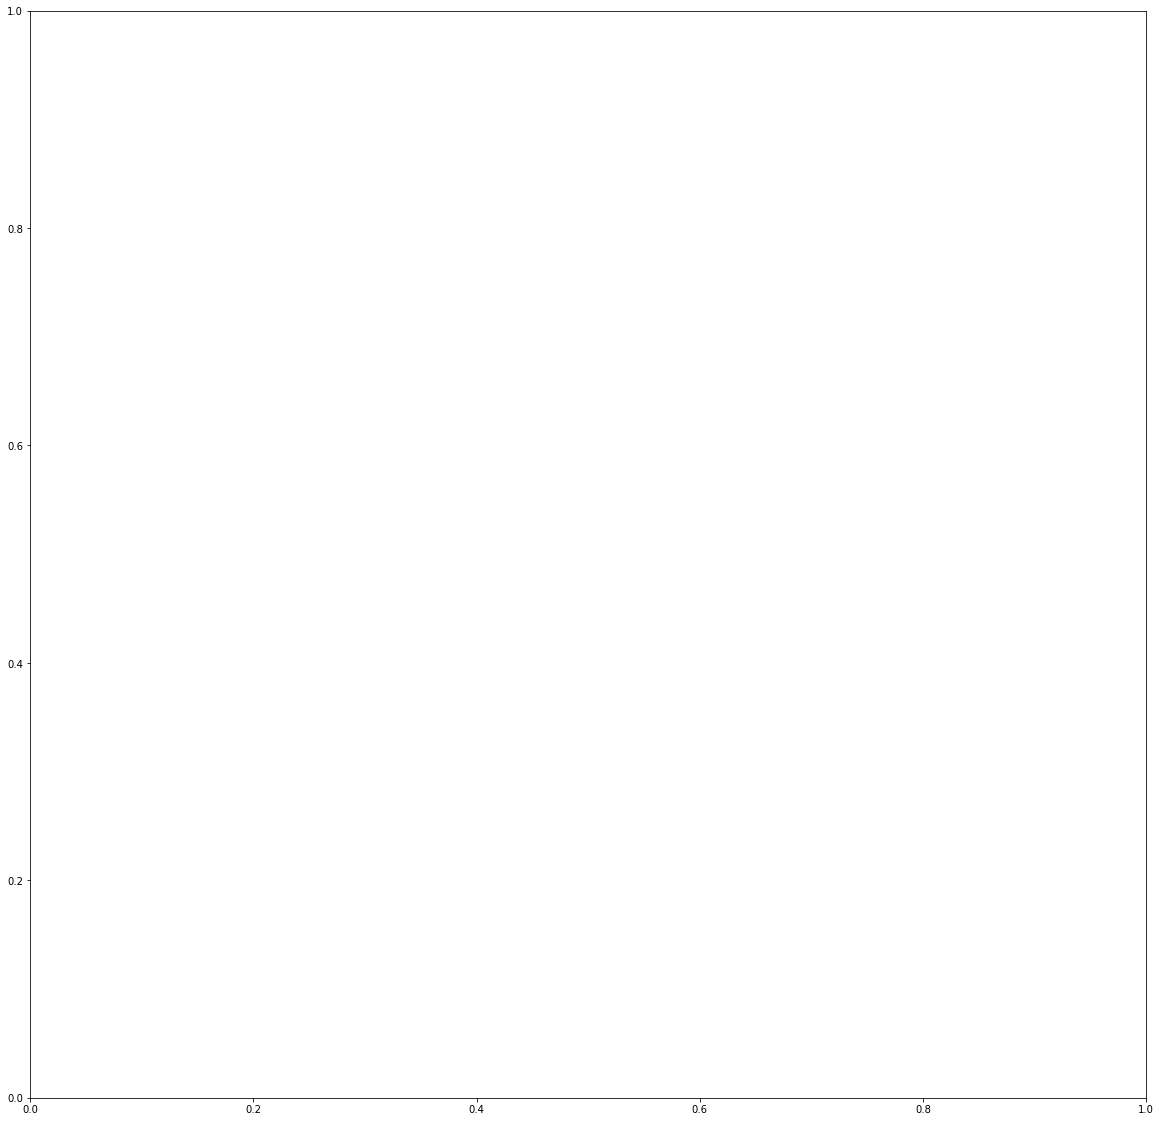

In [113]:
fig , ax1 = plt.subplots(figsize=(20,20))
# nx.draw_networkx
# draw_kamada_kawai
G = nx.from_pandas_edgelist(ndf,
                       source = "word1",
                      target = "word2")
nx.draw(G,
       with_labels=True, font_size = 10,
       node_size = 500)
plt.show()

## Output Clusters

In [187]:
sub_graphs = nx.algorithms.components.connected_components(G)

#n gives the number of sub graphs
# n = len(sub_graphs)

# you can now loop through all nodes in each sub graph
for i in sub_graphs:
    print("Subgraph:", i)

Subgraph: {"'whconv'", "'whconv1'", "'judywhconv'"}
Subgraph: {"'adv12019'", "'adv12292015'"}
Subgraph: {"'advck082619'", "'advck091119'", "'advck092619'", "'advck090919'"}
Subgraph: {"'stmnond17'", "'nonstmnond17'"}
Subgraph: {"'nmc18nonsthnondpostal'", "'nmc18nonsthnondemail'", "'nmc18sthnondemail'"}
Subgraph: {"'advadd1120194122633'", "'advadd'", "'advadd052019'", "'advadd091519'", "'advadd112019634'", "'advadd093019'", "'advadd0930192'", "'advadd1119'", "'advadd052219'", "'advadd112719'", "'advadd112504632'", "'advadd112019'", "'advadd120519'", "'advadd011619'", "'advadd120619'", "'advadd100219'", "'advadd112519'"}
Subgraph: {"'unlinked'", "'fb10unlinked'", "'sgunlinked'", "'linked'"}
Subgraph: {"'studbt15'", "'studbt16'", "'studbt19'", "'studbt17'", "'studbt18'"}
Subgraph: {"'2020gganamepull2'", "'2020gganamepullx'", "'2020gganamepull'", "'2020gganamepull4'", "'2020gganamepullz'", "'2020gganamepull5'"}
Subgraph: {"'student2020'", "'student'"}
Subgraph: {"'u011520'", "'u011520ps'"}